# Experiment 1: False Goal Test
The different ToM models may struggle with learning which goals are relevant to which agents. For example, an agent wants to go to point B. The path the agent takes will go by point A, but historically, this agent does not visit point A. How well do models learn goal relevance for agents?  

We can test this by designing specific paths for the agents. We will choose the highest probability goal for each agent and the lowest probability goal. Then, we will for the agent to start from a position before the low probability goal such that this goal has to be passed on the way to the true goal. As the agent approaches the false goal, are the models fooled with high certainty that this is the correct goal driving the agent?  


## Notes 
All of the models except ToMNet are working right now. I am pretty sure it is because we are just skipping nodes in the path that are not in the graph thus making our jobs much easier without fixing the underlying problem. This is ok for now. ToMNet will work, but we need to figure out how to remove the nodes not in the graph from the path data so it works properly.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import json
import torch

In [3]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [4]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.agents.agent_species import ShortestPathAgent
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color

## Step 1: Loading Data

In [5]:
# # Create a run manager
# run_manager = RunManager('visuals')
# run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Loading graph from ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges


In [6]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [7]:
import json, pickle

with open("./data/data/1k/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/data/1k/goal_data.json", 'r') as file:
    goal_data = json.load(file)

with open('./data/data/1k/agents.pkl', 'rb') as f:
    agents = pickle.load(f)

/var/folders/38/k8ptv94x02v3qc6vywd5sfv40000gn/T/ipykernel_32654/1256136615.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  agents = pickle.load(f)


In [8]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [9]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 2: Choosing Start and Goal

In [10]:
from tqdm import tqdm

In [15]:
to_remove = []
for agent in tqdm(agents, desc="Processing agents"):
    max_goal_idx = np.argmax(agent.goal_distribution)
    max_goal = goals[max_goal_idx]
    
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]

    G = campus.G # your NetworkX graph

    if max_goal not in G.nodes() or min_goal not in G.nodes():
        to_remove.append(agent)
        continue

    candidates = []
    for s in G.nodes():
        if s in (min_goal, max_goal):
            continue  # optional: don't start right on one of the goals
        try:
            path = nx.shortest_path(G, s, max_goal, weight="length")
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            continue
        if min_goal in path:
            candidates.append(s)
    
    if not candidates:
        print("No start node forces a pass by min_goal on the way to max_goal")
        to_remove.append(agent)
        continue

    agent.goal_node = max_goal
    agent.start_node = random.choice(candidates)
    agent.current_node = agent.start_node
    # Remove agent if start node is not in the graph
    if agent.start_node not in G.nodes():
        to_remove.append(agent)
        continue
    try:
        agent.plan_path()
    except nx.NodeNotFound:
        to_remove.append(agent)
        continue

    if min_goal not in agent.path:
        print("Problem, missing min goal in path")

Processing agents:   3%|▎         | 3/100 [00:15<08:09,  5.04s/it]

Problem, missing min goal in path


Processing agents:   9%|▉         | 9/100 [00:58<11:42,  7.73s/it]

Problem, missing min goal in path


Processing agents:  17%|█▋        | 17/100 [01:54<09:40,  7.00s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  18%|█▊        | 18/100 [02:03<10:19,  7.56s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  22%|██▏       | 22/100 [02:32<09:42,  7.47s/it]

Problem, missing min goal in path


Processing agents:  28%|██▊       | 28/100 [03:24<10:05,  8.40s/it]

Problem, missing min goal in path


Processing agents:  35%|███▌      | 35/100 [04:16<08:49,  8.14s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  40%|████      | 40/100 [04:54<07:09,  7.16s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  45%|████▌     | 45/100 [05:30<06:27,  7.05s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  48%|████▊     | 48/100 [05:57<07:21,  8.49s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  50%|█████     | 50/100 [06:10<06:19,  7.58s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  51%|█████     | 51/100 [06:19<06:28,  7.92s/it]

Problem, missing min goal in path


Processing agents:  59%|█████▉    | 59/100 [07:13<04:25,  6.48s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  77%|███████▋  | 77/100 [09:19<02:23,  6.24s/it]

Problem, missing min goal in path


Processing agents:  91%|█████████ | 91/100 [11:03<01:11,  7.93s/it]

Problem, missing min goal in path


Processing agents:  94%|█████████▍| 94/100 [11:23<00:41,  6.93s/it]

No start node forces a pass by min_goal on the way to max_goal


Processing agents:  99%|█████████▉| 99/100 [11:53<00:06,  6.30s/it]

Problem, missing min goal in path


Processing agents: 100%|██████████| 100/100 [12:00<00:00,  7.20s/it]


In [14]:
agents = [agent for agent in agents if agent not in to_remove]

In [15]:
# save it as a pickle file
with open('./../data/1k/agents_preprocessed_2.pkl', 'wb') as f:
    pickle.dump(agents, f)

In [12]:
with open('./data/data/1k/agents_processed.pkl', 'rb') as f:
    agents = pickle.load(f)

In [13]:
# Get each agent's path 
for agent in agents:
    agent.plan_path()

## Step 3: Run the Models

### BToM

In [14]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [15]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [16]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

In [17]:
for agent in agents:
    valid_path = [n for n in agent.path if n in btom.campus.G.nodes]
    if len(valid_path) < 2:
        print(f"Skipping agent {agent.id}: not enough valid nodes in path.")
        continue
    posteriors_data[agent.id] = btom.update_agent_posterior_over_path(agent, valid_path)
btom.reset_posteriors()

### Extended BToM

In [18]:
from real_world_src.models.extended_btom import Extended_BToM

In [20]:
with open('./data/trained_models/extended_btom.pkl', 'rb') as f:
    ext_btom = pickle.load(f)

In [21]:
# Calculate all the posteriors using the first 30 episode
ext_posteriors_data = {}
for agent in agents:
    valid_path = [n for n in agent.path if n in ext_btom.campus.G.nodes]
    if len(valid_path) < 2:
        print(f"Skipping agent {agent.id}: not enough valid nodes in path.")
        continue
    ext_posteriors_data[agent.id] = ext_btom.update_agent_posterior_over_path(agent, valid_path)

# LSTM

In [28]:
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior
)
from torch.utils.data import DataLoader

In [29]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [30]:
# Filter path_data to only include valid nodes (like BTOM code)
filtered_path_data = {}
for episode, agents_dict in path_data.items():
    filtered_path_data[episode] = {}
    for agent_id, path in agents_dict.items():
        filtered_path = [n for n in path if n in node2idx]
        filtered_path_data[episode][agent_id] = filtered_path

lstm_dataset = LSTMDataset(filtered_path_data, goal_data, node2idx, goal2idx)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn)


In [31]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [32]:
lstm_model = SimpleLSTM(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_lstm_model(lstm_model, lstm_loader, optimizer, device, num_epochs=10)

 10%|█         | 1/10 [00:17<02:41, 18.00s/it]

Epoch 1/10 - Loss: 1.8774


 20%|██        | 2/10 [00:35<02:23, 17.94s/it]

Epoch 2/10 - Loss: 1.5465


 30%|███       | 3/10 [00:54<02:08, 18.32s/it]

Epoch 3/10 - Loss: 1.3925


 40%|████      | 4/10 [01:14<01:53, 18.86s/it]

Epoch 4/10 - Loss: 0.9691


 50%|█████     | 5/10 [01:34<01:35, 19.20s/it]

Epoch 5/10 - Loss: 0.2044


 60%|██████    | 6/10 [01:53<01:16, 19.24s/it]

Epoch 6/10 - Loss: 0.1375


 70%|███████   | 7/10 [02:12<00:57, 19.02s/it]

Epoch 7/10 - Loss: 0.0427


 80%|████████  | 8/10 [02:30<00:37, 18.84s/it]

Epoch 8/10 - Loss: 0.0275


 90%|█████████ | 9/10 [02:49<00:18, 18.88s/it]

Epoch 9/10 - Loss: 0.0097


100%|██████████| 10/10 [03:08<00:00, 18.80s/it]

Epoch 10/10 - Loss: 0.0136


In [33]:
evaluate_lstm_model(lstm_model, lstm_loader, device)

Evaluation accuracy: 0.9988


0.99881

In [34]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [35]:
# Compute posteriors along paths for all test agents (LSTM)
lstm_posteriors = {}
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    # Filter path to only include valid nodes, like BTOM code
    valid_path = [n for n in agent.path if n in node2idx]
    posteriors_along_path = []
    for t in range(1, len(valid_path)+1):
        subpath = valid_path[:t]
        posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
        posteriors_along_path.append(posterior)
    lstm_posteriors[agent.id] = posteriors_along_path

In [44]:
# Save LSTM model weights
torch.save(lstm_model.state_dict(), "lstm_model_state.pth")
print("Saved lstm_model_state.pth")

Saved lstm_model_state.pth


# GRU

In [36]:
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

In [37]:
# Filter path_data to only include valid nodes (like BTOM code)
filtered_gru_path_data = {}
for episode, agents_dict in path_data.items():
    filtered_gru_path_data[episode] = {}
    for agent_id, path in agents_dict.items():
        filtered_path = [n for n in path if n in node2idx]
        filtered_gru_path_data[episode][agent_id] = filtered_path

gru_dataset = GRUDataset(filtered_gru_path_data, goal_data, node2idx, goal2idx)
gru_loader = DataLoader(gru_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

In [38]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [39]:
gru_model = SimpleGRU(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
train_gru_model(gru_model, gru_loader, optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 0.5288
Epoch 2/10, Loss: 0.0036
Epoch 3/10, Loss: 0.0010
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0000


KeyboardInterrupt: 

In [40]:
evaluate_gru_model(gru_model, gru_loader, device)

Evaluation accuracy: 1.0000


1.0

In [41]:
# Save GRU model weights
torch.save(gru_model.state_dict(), "gru_model_state.pth")
print("Saved gru_model_state.pth")

Saved gru_model_state.pth


In [42]:
from tqdm import tqdm

In [75]:
# Compute posteriors along paths for all test agents(GRU)
gru_posteriors = {}
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    # Filter path to only include valid nodes, like BTOM and LSTM code
    valid_path = [n for n in agent.path if n in node2idx]
    posteriors_along_path = []
    for t in range(1, len(valid_path)+1):
        subpath = valid_path[:t]
        posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
        posteriors_along_path.append(posterior)
    gru_posteriors[agent.id] = posteriors_along_path

### ToMNet

In [52]:
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        if isinstance(path, (list, tuple, set)):
            all_nodes.update(path)
        else:
            all_nodes.add(path)
all_nodes.update(campus.G_undirected.nodes())
all_nodes = list(all_nodes)

node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}

# Adjust the path if needed
node_embeddings = np.load("./data/data/data_utils/node2vec_embeddings_3185.npy")

Number of nodes in node2idx: 3185


In [59]:
import torch
from real_world_src.models.tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists, make_support_tensor
from torch.utils.data import Dataset, DataLoader

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# the values you trained with:
K     = 10
T_sup = 50
T_q   = 20


model = ToMNet(
    node_embeddings,
    num_nodes = len(all_nodes),
    #num_nodes=3108,
    num_goals = len(goals),
    K     = K,
    T_sup = T_sup,
    T_q   = T_q,
    #h_char= 64, 
    #h_ment = 64, 
    #z_dim = 32
    ).to(device)

state_dict = torch.load(
    "./data/trained_models/New_Tomnet_1k_3185_2ep.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()

ToMNet(
  (char_net): CharacterNet(
    (embedding): Embedding(3185, 64, padding_idx=0)
    (lstm): LSTM(64, 64, batch_first=True)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc_mu): Linear(in_features=64, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=64, out_features=64, bias=True)
  )
  (mental_net): MentalNet(
    (embedding): Embedding(3185, 64, padding_idx=0)
    (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attn): Linear(in_features=128, out_features=1, bias=True)
    (fc_mu): Linear(in_features=128, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  )
  (embedding): Embedding(3185, 64, padding_idx=0)
  (fusion): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): LayerNorm((1

In [ ]:
# # build node2idx so that every node in campus.G_undirected maps to 0…V−1
# all_nodes = list(campus.G_undirected.nodes())
# node2idx  = {n:i for i,n in enumerate(all_nodes)}
# V = len(all_nodes)

# # build goal2idx likewise for your goals list
# goal2idx = {g:i for i,g in enumerate(goals)}
# G = len(goals)

In [62]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [87]:
filtered_path_data = {}
removed_node_count = 0
total_node_count = 0

for episode, agent_paths in path_data.items():
    filtered_path_data[episode] = {}
    for agent_id, path in agent_paths.items():
        original_len = len(path)
        total_node_count += original_len
        filtered_path = [node for node in path if node in node2idx]
        removed_node_count += original_len - len(filtered_path)
        filtered_path_data[episode][agent_id] = filtered_path

print(f"Total nodes removed: {removed_node_count} out of {total_node_count} "
      f"({removed_node_count / total_node_count:.4f})")

Total nodes removed: 69630 out of 4241222 (0.0164)


In [88]:
len(filtered_path_data)

1000

In [92]:
tomnet_posteriors = {}

for agent in agents:

    if agent.id not in test_agent_ids:
        continue

    dists = infer_goal_dists(
        model, agent.id, episode, filtered_path_data,
        node2idx, goal2idx,
        K=10, T_sup=50, T_q=20, device=device
    )


    tomnet_posteriors[agent.id] = get_posterior_format(dists)


## Step 4: Calculate Brier Score  
We will calculate the brier score for each 10% portion of the path (same as before), but only leading up to the false goal. A model that does not learn historical trends will have a higher brier score since it will be more confident in the false goal. 

In [64]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path, fooled_along_path

In [112]:
btom_scores = []
for agent in agents:
    valid_path = [n for n in agent.path if n in btom.campus.G.nodes]
    btom_scores.append(brier_along_path(valid_path, 
                              agent.goal_node, 
                              posteriors_data[agent.id], 
                              goals))

ext_scores = []
for agent in agents:
    valid_path = [n for n in agent.path if n in ext_btom.campus.G.nodes]
    ext_scores.append(brier_along_path(valid_path, 
                              agent.goal_node, 
                              ext_posteriors_data[agent.id], 
                              goals))

    
tomnet_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    if agent.id not in tomnet_posteriors:
        continue  # Skip if no posterior for this agent

    path = filtered_path_data[episode][agent.id]
    posteriors = tomnet_posteriors[agent.id]
    min_len = min(len(path), len(posteriors))
    if min_len == 0:
        continue
    tomnet_scores.append(brier_along_path(
        path[:min_len],
        goal_data[episode][agent.id],
        posteriors[:min_len],
        goals
    ))
    
lstm_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    if agent.id not in lstm_posteriors:
        continue  # Skip if no posterior for this agent
    valid_path = [n for n in agent.path if n in node2idx]
    lstm_scores.append(brier_along_path(valid_path, 
                              agent.goal_node, 
                              lstm_posteriors[agent.id], 
                              goals))

gru_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    if agent.id not in gru_posteriors:
        continue  # Skip if no posterior for this agent
    valid_path = [n for n in agent.path if n in node2idx]
    gru_scores.append(brier_along_path(valid_path, 
                              agent.goal_node, 
                              gru_posteriors[agent.id], 
                              goals))

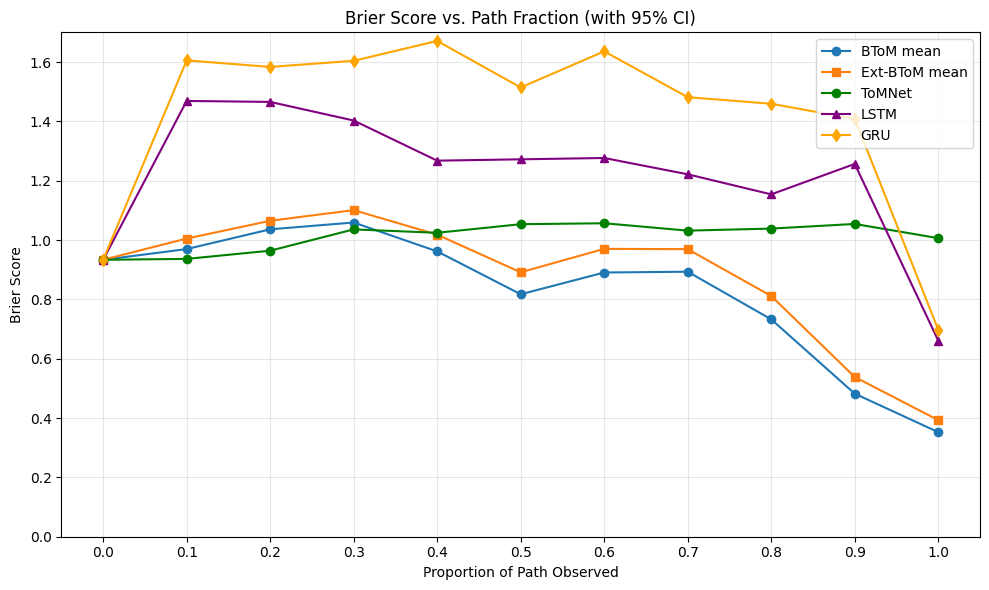

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` and `ext_scores` are your (N × 11) arrays:
arr      = np.array(btom_scores)      # shape (N, 11)
ext_arr  = np.array(ext_scores)  # same shape
tomnet_arr = np.array(tomnet_scores)
lstm_arr= np.array(lstm_scores)
gru_arr= np.array(gru_scores)
props = np.linspace(0, 1, arr.shape[1])


# Compute means 
mean_b = arr.mean(axis=0)
mean_e = ext_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)


plt.figure(figsize=(10,6))

# BToM curve
plt.plot(props, mean_b, '-o', color='C0', label='BToM mean')
# Extended BToM curve
plt.plot(props, mean_e, '-s', color='C1', label='Ext-BToM mean')
# Tomnet curve
plt.plot(props, mean_tomnet, '-o', color='green', label='ToMNet')
#LSTM curve
plt.plot(props, mean_lstm, '-^', color='purple', label='LSTM')
#GRU curve
plt.plot(props, mean_gru, '-d', color='orange', label='GRU')


plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction (with 95% CI)')
plt.xticks(props)
plt.ylim(0, 1.7)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
fooled_scores = []
for agent in agents:
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    path = agent.path
    if min_goal not in path:
        continue  # Skip if min_goal is not in the path
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    fooled_scores.append(fooled_along_path(path, 
                                agent.goal_node,
                                min_goal,
                                posteriors_data[agent.id],
                                goals))

ext_fooled_scores = []
for agent in agents:
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    path = agent.path
    if min_goal not in path:
        continue
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    ext_fooled_scores.append(fooled_along_path(path, 
                                agent.goal_node,
                                min_goal,
                                ext_posteriors_data[agent.id],
                                goals))

tomnet_fooled_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    if agent.id not in tomnet_posteriors:
        continue  # Skip if no posterior for this agent
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    path = filtered_path_data[episode][agent.id]
    if min_goal not in path:
        continue
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    tomnet_fooled_scores.append(fooled_along_path(path, 
                                agent.goal_node,
                                min_goal,
                                tomnet_posteriors[agent.id],
                                goals))
    

lstm_fooled_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    path = agent.path
    if min_goal not in path or agent.id not in lstm_posteriors:
        continue
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    lstm_fooled_scores.append(fooled_along_path(path, 
                                agent.goal_node,
                                min_goal,
                                lstm_posteriors[agent.id],
                                goals))

gru_fooled_scores = []
for agent in agents:
    if agent.id not in test_agent_ids:
        continue
    min_goal_idx = np.argmin(agent.goal_distribution)
    min_goal = goals[min_goal_idx]
    path = agent.path
    if min_goal not in path or agent.id not in gru_posteriors:
        continue
    false_goal_idx = path.index(min_goal)
    path = path[:false_goal_idx + 1]
    gru_fooled_scores.append(fooled_along_path(path, 
                                agent.goal_node,
                                min_goal,
                                gru_posteriors[agent.id],
                                goals))

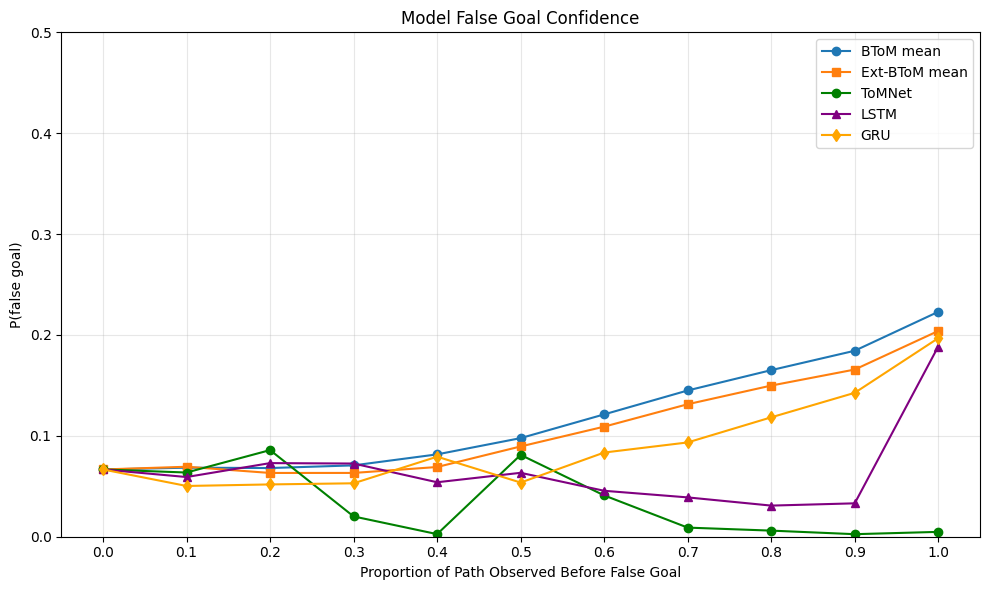

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# your two (n_trajectories × n_fractions) arrays:
arr      = np.array(fooled_scores)      # original BToM
ext_arr  = np.array(ext_fooled_scores)  # extended BToM
tomnet_arr = np.array(tomnet_fooled_scores)
lstm_arr= np.array(lstm_fooled_scores)
gru_arr= np.array(gru_fooled_scores)

props = np.linspace(0, 1, arr.shape[1])

# --- original BToM stats ---
mean_b = arr.mean(axis=0)

# --- extended BToM stats ---
mean_e = ext_arr.mean(axis=0)

mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
# Plotting the results


plt.figure(figsize=(10,6))

# original BToM
plt.plot(props, mean_b, '-o', color='C0', label='BToM mean')

# extended BToM
plt.plot(props, mean_e, '-s', color='C1', label='Ext‐BToM mean')
# Tomnet curve
plt.plot(props, mean_tomnet, '-o', color='green', label='ToMNet')
#LSTM curve
plt.plot(props, mean_lstm, '-^', color='purple', label='LSTM')
#GRU curve
plt.plot(props, mean_gru, '-d', color='orange', label='GRU')



plt.xlabel('Proportion of Path Observed Before False Goal')
plt.ylabel('P(false goal)')
plt.title('Model False Goal Confidence')
plt.xticks(props)
plt.ylim(0, 0.5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()